# Importing Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import load_model
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Importing Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DIR_MAIN = '/content/drive/MyDrive/CCPS Summer Internship/SplitDataset/'

TEST_DIR = DIR_MAIN + 'test'
TRAIN_DIR = DIR_MAIN + 'train'
VAL_DIR = DIR_MAIN + 'val'

In [ ]:
IMG_SHAPE  = 224
batch_size = 32

# Data Generators

In [ ]:
image_gen_train = ImageDataGenerator(rescale = 1./255)

train_data_gen = image_gen_train.flow_from_directory(
    batch_size = batch_size,
    directory = TRAIN_DIR,
    shuffle= True,
    target_size = (IMG_SHAPE,IMG_SHAPE),
    class_mode = 'categorical')


image_generator_validation = ImageDataGenerator(rescale=1./255)

val_data_gen = image_generator_validation.flow_from_directory(
    batch_size=batch_size,
    directory=VAL_DIR,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode='categorical')

image_gen_test = ImageDataGenerator(rescale=1./255)

test_data_gen = image_gen_test.flow_from_directory(
    batch_size=batch_size,
    directory=TEST_DIR,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode='categorical')

Found 2677 images belonging to 4 classes.
Found 764 images belonging to 4 classes.
Found 385 images belonging to 4 classes.


In [ ]:
dataset_labels = sorted(train_data_gen.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Benign' 'Early' 'Pre' 'Pro']


# Xception Model

In [ ]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout

In [ ]:

# Defining the pretrained base model
base = Xception(include_top=False, weights='imagenet', input_shape=(224,224,3))
x = base.output
x = GlobalAveragePooling2D()(x)
# Defining the head of the model where the prediction is conducted
head = Dense(4, activation='softmax')(x)
# Combining base and head
model = Model(inputs=base.input, outputs=head)

83683744/83683744 [==============================] - 4s 0us/step


In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
# Compiling the model
model.compile(optimizer=Adam(lr=0.0001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [ ]:
steps_per_epoch = np.ceil(train_data_gen.samples/train_data_gen.batch_size)
val_steps_per_epoch = np.ceil(val_data_gen.samples/val_data_gen.batch_size)
hist = model.fit(
train_data_gen,
epochs=10,
verbose=1,
steps_per_epoch=steps_per_epoch,
validation_data=val_data_gen,
validation_steps=val_steps_per_epoch).history

Epoch 1/10
84/84 [==============================] - 46s 542ms/step - loss: 0.0921 - accuracy: 0.9701 - val_loss: 0.5887 - val_accuracy: 0.8665
Epoch 2/10
84/84 [==============================] - 50s 591ms/step - loss: 0.0617 - accuracy: 0.9795 - val_loss: 0.2428 - val_accuracy: 0.9254
Epoch 3/10
84/84 [==============================] - 49s 586ms/step - loss: 0.0362 - accuracy: 0.9877 - val_loss: 1.0218 - val_accuracy: 0.8547
Epoch 4/10
84/84 [==============================] - 49s 580ms/step - loss: 0.0697 - accuracy: 0.9795 - val_loss: 0.6037 - val_accuracy: 0.8416
Epoch 5/10
84/84 [==============================] - 50s 591ms/step - loss: 0.0573 - accuracy: 0.9791 - val_loss: 0.2692 - val_accuracy: 0.9503
Epoch 6/10
84/84 [==============================] - 49s 586ms/step - loss: 0.0247 - accuracy: 0.9910 - val_loss: 0.2677 - val_accuracy: 0.9450
Epoch 7/10
84/84 [==============================] - 49s 578ms/step - loss: 0.0292 - accuracy: 0.9892 - val_loss: 0.1700 - val_accuracy: 0.9437

# Exporting Model

In [ ]:
# Saving the model
ALL_SAVED_MODEL_PATH = '/content/gdrive/MyDrive/CCPS Summer Internship/NewModels/Xceptiontry2.h5'
model.save(ALL_SAVED_MODEL_PATH)

In [ ]:
test_image_batch, test_label_batch = next(iter(test_data_gen))
true_label_ids = np.argmax(test_label_batch, axis=-1)
print("Test batch shape:", test_image_batch.shape)

Test batch shape: (32, 224, 224, 3)


In [ ]:
results = model.evaluate(test_image_batch, test_label_batch)

In [ ]:
results

# Testing Model

In [ ]:
import pandas as pd

In [ ]:
tf_model_predictions = model.predict(test_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results of Xception for the first elements")
tf_pred_dataframe.head()

1/1 [==============================] - 0s 32ms/step
Prediction results of Xception for the first elements


,Benign,Early,Pre,Pro
0,8.919770e-12,2.607585e-13,7.678312e-13,1.000000e+00
1,6.739504e-10,3.247773e-10,1.076000e-10,1.000000e+00
2,6.663373e-06,2.164947e-07,1.821855e-07,9.999928e-01
3,2.423760e-09,9.538565e-10,1.000000e+00,9.568289e-13
4,6.956068e-13,4.125498e-15,1.000000e+00,1.980673e-16


In [ ]:
import matplotlib.pyplot as plt

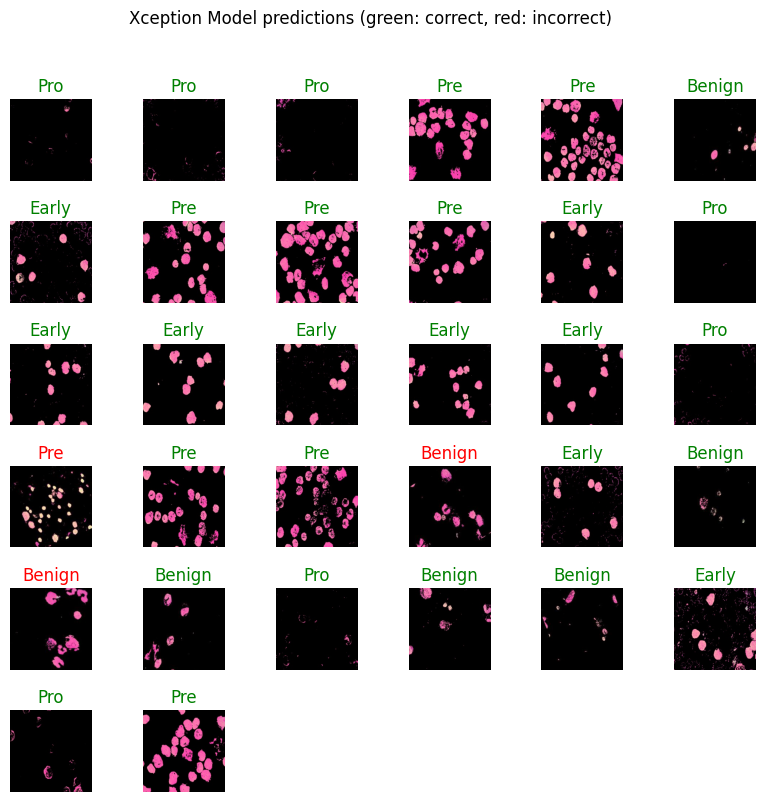

In [ ]:
predicted_ids_Xception = np.argmax(tf_model_predictions, axis=-1)
predicted_labels_Xception = dataset_labels[predicted_ids_Xception]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(32):
  plt.subplot(6,6,n+1)
  plt.imshow(test_image_batch[n])
  color = "green" if predicted_ids_Xception[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels_Xception[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Xception Model predictions (green: correct, red: incorrect)")

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
claRep = classification_report(true_label_ids, predicted_ids_Xception)
claRep

'              precision    recall  f1-score   support\n\n           0       0.71      0.83      0.77         6\n           1       1.00      1.00      1.00         9\n           2       0.89      1.00      0.94         8\n           3       1.00      0.78      0.88         9\n\n    accuracy                           0.91        32\n   macro avg       0.90      0.90      0.90        32\nweighted avg       0.92      0.91      0.91        32\n'

In [ ]:
cm = confusion_matrix(true_label_ids, predicted_ids_Xception)
accuracy = accuracy_score(true_label_ids, predicted_ids_Xception)
precision = precision_score(true_label_ids, predicted_ids_Xception, average='macro')
recall = recall_score(true_label_ids, predicted_ids_Xception, average='macro')
f1 = f1_score(true_label_ids, predicted_ids_Xception, average='macro')

# Print the metrics
print("Confusion Matrix:\n", cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Confusion Matrix:
 [[5 0 1 0]
 [0 9 0 0]
 [0 0 8 0]
 [2 0 0 7]]
Accuracy: 0.90625
Precision: 0.9007936507936508
Recall: 0.9027777777777778
F1 Score: 0.8963518099547512


https://www.kaggle.com/code/akdagmelih/multi-class-ship-classification-xception